In [1]:
import numpy as np

In [2]:
class MultiClassNetwork:
    
    def __init__(self, units=10,batch_size=32, learning_rate=0.1, l1=0,l2=0):
        self.units=units
        self.batch_size=batch_size
        self.w1=None
        self.b1=None
        self.w2=None
        self.b2=None
        self.a1=None
        self.losses=[]
        self.val_losses=[]
        self.lr=learning_rate
        self.l1=l1
        self.l2=l2
        
    def forpass(self,x):
        z1=np.dot(x,self.w1)+self.b1
        self.a1=self.sigmoid(z1)
        z2=np.dot(self.a1,self.w2)+self.b2
        return z2
    
    def backprop(self,x,err):
        m=len(x)
        w2_grad=np.dot(self.a1.T,err)/m
        b2_grad=np.sum(err)/m
        err_to_hidden=np.dot(err,self.w2.T)*self.a1*(1-self.a1)
        w1_grad=np.dot(x.T,err_to_hidden)/m
        b1_grad=np.sum(err_to_hidden,axis=0)/m
        return w1_grad,b1_grad,w2_grad,b2_grad
    
    def sigmoid(self,z):
        a=1/(1+np.exp(-z))
        return a
    
    def softmax(self,z):
        exp_z=np.exp(z)
        return exp_z/np.sum(exp_z,axis=1).reshape(-1,1)
    
    def init_weights(self, n_features, n_classes):
        self.w1=np.random.normal(0,1,(n_features,self.units))
        self.b1=np.zeros(self.units)
        self.w2=np.random.normal(0,1,(self.units,n_classes))
        self.b2=np.zeros(n_classes)
        
    def fit(self,x,y,epochs=100,x_val=None,y_val=None):
        np.random.seed(42)
        self.init_weights(x.shape[1],y.shape[1])  
        for i in range(epochs):
            loss=0
            print('.',end='')
            for x_batch,y_batch in self.gen_batch(x,y):
                a=self.training(x_batch,y_batch)
                a=np.clip(a,1e-10,1-1e-10)     #없어도 될듯?
                loss+=np.sum(-y_batch*np.log(a))
            self.losses.append((loss+self.reg_loss())/len(x))
            self.update_val_loss(x_val,y_val)
        
    def gen_batch(self,x,y):
        length=len(x)
        bins=length//self.batch_size
        if length % self.batch_size:
            bins+=1
        indexes=np.random.permutation(np.arange(len(x)))
        x=x[indexes]
        y=y[indexes]
        for i in range(bins):
            start=self.batch_size*i
            end=self.batch_size*(i+1)
            yield x[start:end],y[start:end]
            
    def training(self,x,y):
        m=len(x)
        z=self.forpass(x)
        a=self.softmax(z)
        err=-(y-a)
        w1_grad,b1_grad,w2_grad,b2_grad=self.backprop(x,err)
        w1_grad+=(self.l1*np.sign(self.w1)+self.l2*self.w1)/m
        w2_grad+=(self.l1*np.sign(self.w2)+self.l2*self.w2)/m
        self.w1-=self.lr*w1_grad
        self.b1-=self.lr*b1_grad
        self.w2-=self.lr*w2_grad
        self.b2-=self.lr*b2_grad
        return a
    
    def predict(self,x):
        z=self.forpass(x)
        return np.argmax(z,axis=1)
    
    def score(self,x,y):
        return np.mean(self.predict(x)==np.argmax(y,axis=1))
    
    def reg_loss(self):
        return self.l1*(np.sum(np.abs(self.w1))+np.sum(np.abs(self.w2)))+self.l2/2*(np.sum(self.w1**2)+np.sum(self.w2**2))
    
    def update_val_loss(self,x_val,y_val):
        z=self.forpass(x_val)
        a=self.softmax(z)
        a=np.clip(a,1e-10,1-1e-10)
        val_loss=np.sum(-y_val*np.log(a))
        self.val_losses.append((val_loss+self.reg_loss())/len(y_val))

In [3]:
import tensorflow as tf
tf.__version__

'2.4.0'

In [4]:
(x_train_all,y_train_all),(x_test,y_test)=tf.keras.datasets.fashion_mnist.load_data()

In [5]:
print(x_train_all.shape,y_train_all.shape)

(60000, 28, 28) (60000,)


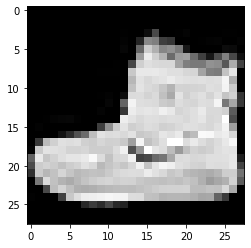

In [6]:
import matplotlib.pyplot as plt
plt.imshow(x_train_all[0],cmap='gray')
plt.show()

In [7]:
print(y_train_all[:10])

[9 0 0 3 0 2 7 2 5 5]


In [8]:
class_names=['티셔츠/윗도리','바지','스웨터','드레스','코트','샌들','셔츠','스니커즈','가방','앵클부츠']

In [9]:
print(class_names[y_train_all[0]])

앵클부츠


In [10]:
np.bincount(y_train_all)

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000],
      dtype=int64)

In [11]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = train_test_split(x_train_all,y_train_all,stratify=y_train_all,test_size=0.2,random_state=42)

In [12]:
np.bincount(y_train)


array([4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800],
      dtype=int64)

In [13]:
np.bincount(y_val)

array([1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200],
      dtype=int64)

In [14]:
x_train=x_train/255
x_val=x_val/255

In [15]:
x_train=x_train.reshape(-1,784)
x_val=x_val.reshape(-1,784)

In [16]:
print(x_train.shape,x_val.shape)

(48000, 784) (12000, 784)


In [17]:
tf.keras.utils.to_categorical([0,1,3])

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [18]:
y_train_encoded=tf.keras.utils.to_categorical(y_train)
y_val_encoded=tf.keras.utils.to_categorical(y_val)
print(y_train_encoded.shape,y_val_encoded.shape)

(48000, 10) (12000, 10)


In [19]:
print(y_train[0],y_train_encoded[0])

6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [20]:
fc=MultiClassNetwork(units=100,batch_size=256)
fc.fit(x_train,y_train_encoded,x_val=x_val,y_val=y_val_encoded,epochs=40)

........................................

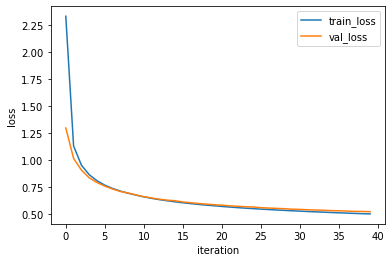

In [21]:
plt.plot(fc.losses)
plt.plot(fc.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss','val_loss'])
plt.show()

In [22]:
fc.score(x_val,y_val_encoded)

0.8150833333333334

# 7-2. 텐서플로와 케라스

In [23]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
model=Sequential()
model.add(Dense(100,activation='sigmoid',input_shape=(784,)))
model.add(Dense(10,activation='softmax'))
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])

In [24]:
history=model.fit(x_train,y_train_encoded,epochs=40,validation_data=(x_val,y_val_encoded))

Epoch 1/40
1500/1500 [==============================] - 4s 2ms/step - loss: 1.7083 - accuracy: 0.5387 - val_loss: 0.9627 - val_accuracy: 0.7271
Epoch 2/40
1500/1500 [==============================] - 2s 2ms/step - loss: 0.8962 - accuracy: 0.7394 - val_loss: 0.7520 - val_accuracy: 0.7631
Epoch 3/40
1500/1500 [==============================] - 2s 1ms/step - loss: 0.7344 - accuracy: 0.7628 - val_loss: 0.6642 - val_accuracy: 0.7794
Epoch 4/40
1500/1500 [==============================] - 2s 1ms/step - loss: 0.6582 - accuracy: 0.7775 - val_loss: 0.6126 - val_accuracy: 0.7948
Epoch 5/40
1500/1500 [==============================] - 2s 1ms/step - loss: 0.6118 - accuracy: 0.7944 - val_loss: 0.5774 - val_accuracy: 0.8038
Epoch 6/40
1500/1500 [==============================] - 2s 1ms/step - loss: 0.5795 - accuracy: 0.8027 - val_loss: 0.5519 - val_accuracy: 0.8079
Epoch 7/40
1500/1500 [==============================] - 2s 2ms/step - loss: 0.5566 - accuracy: 0.8099 - val_loss: 0.5301 - val_accuracy:

In [25]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


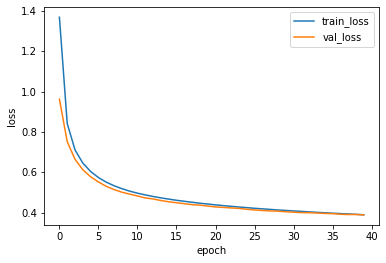

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

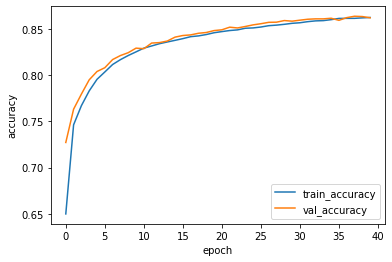

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

In [28]:
loss,accuracy=model.evaluate(x_val,y_val_encoded,verbose=0)
print(accuracy)

0.8619166612625122


In [29]:
x_test=x_test/255
y_test_encoded=tf.keras.utils.to_categorical(y_test)
#loss,accuracy=model.evaluate(x_test,y_test_encoded)
#print(accuracy)